## Сделал:

Разметил данные (параметры - n, thresh - длина прогноза и порог чувствительности)

Запустил RF на данных, результат акураси - 0.3, то есть случайное блуждание

выбирать thresh в процентах, а не абсолютных значениях

запустить RF на окне определенной длины (длина - гиперпараметр)

автоматически подбирать window_len

автоматически подбирать thresh, чтобы классы были сбалансированны или как-то еще

кросс-валидация при оценке качества

провести симуляцию торгов:
1. со знанием исторических данных
2. с использованием алгоритмов мл (логрег, рф)

логрег

## Сделать:


сравнить rf с другими моделями классификации

подбирать другие параметры rf

провести симуляцию с использованием наивного алгоритма (какого?)


## Разбиение на классы

Предпосылки

1. Датасет нужно разделить на классы "продавать","покупать","держать"
2. Предлагается ввести "порог", через который должна переступить разница в цене в процентах за определенный период, чтобы можно было принять решение о покупке/продаже
3. Классы должны быть сбалансированы, чтобы было проще решать и оценивать решение задачи классификации

Вариант решения

https://stats.stackexchange.com/questions/387835/measuring-class-imbalance-of-a-dataset - про сбалансированность датасета

1. Введем функцию, которая в зависимости от порога дает разбитый на классы датасет

2. Посчитаем сбалансированность датасета как 
$$J(t) = \sum_i{|IdealSection - PartOfClass_i(t)|}$$
по сути, это оценка насколько датасет отличается от идеально сбалансированного (функционал оценки качества разбиения)
3. Оптимизируем $J$ по $t$

Проблема - J негладкая функция, оптимизировать сложно 
Будем оптимизировать одномерным методом с ограничениями от 0 до 100 (т.к. проценты)

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
sys.path.append('../')

In [31]:
import numpy as np
import pandas as pd
import os
import sys
from scipy.optimize import minimize_scalar
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import plotly.express as px
import warnings

from src.trade import Simulation, add_results_to_df, get_simulation_results
from src.trade.prepare_data import prepare_data, prepare_data_without_window, generate_window

In [32]:
warnings.simplefilter("ignore")

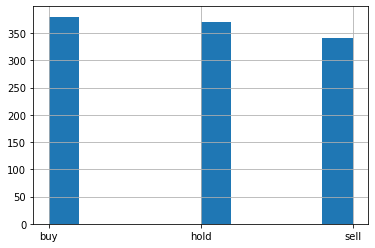

In [33]:
n = 3
window_len = 10
df = prepare_data(n=n, window_len=window_len)
df.label.hist()

In [34]:
df

,target,diff,diff_percent,label,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10
Date,,,,,,,,,,,,,,
2018-01-22,63.490002,NaN,3.181604,buy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-23,64.470001,NaN,2.590349,buy,63.490002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-24,65.610001,NaN,0.807802,hold,64.470001,63.490002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-25,65.510002,2.020000,0.961681,hold,65.610001,64.470001,63.490002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-26,66.139999,1.669998,-0.876931,hold,65.510002,65.610001,64.470001,63.490002,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-16,52.360001,-0.549999,1.184108,buy,52.360001,53.570000,52.910000,53.209999,52.250000,52.240002,52.240002,52.240002,50.830002,50.630001
2021-01-17,52.360001,-1.209999,1.680674,buy,52.360001,52.360001,53.570000,52.910000,53.209999,52.250000,52.240002,52.240002,52.240002,50.830002
2021-01-18,52.360001,0.000000,NaN,None,52.360001,52.360001,52.360001,53.570000,52.910000,53.209999,52.250000,52.240002,52.240002,52.240002


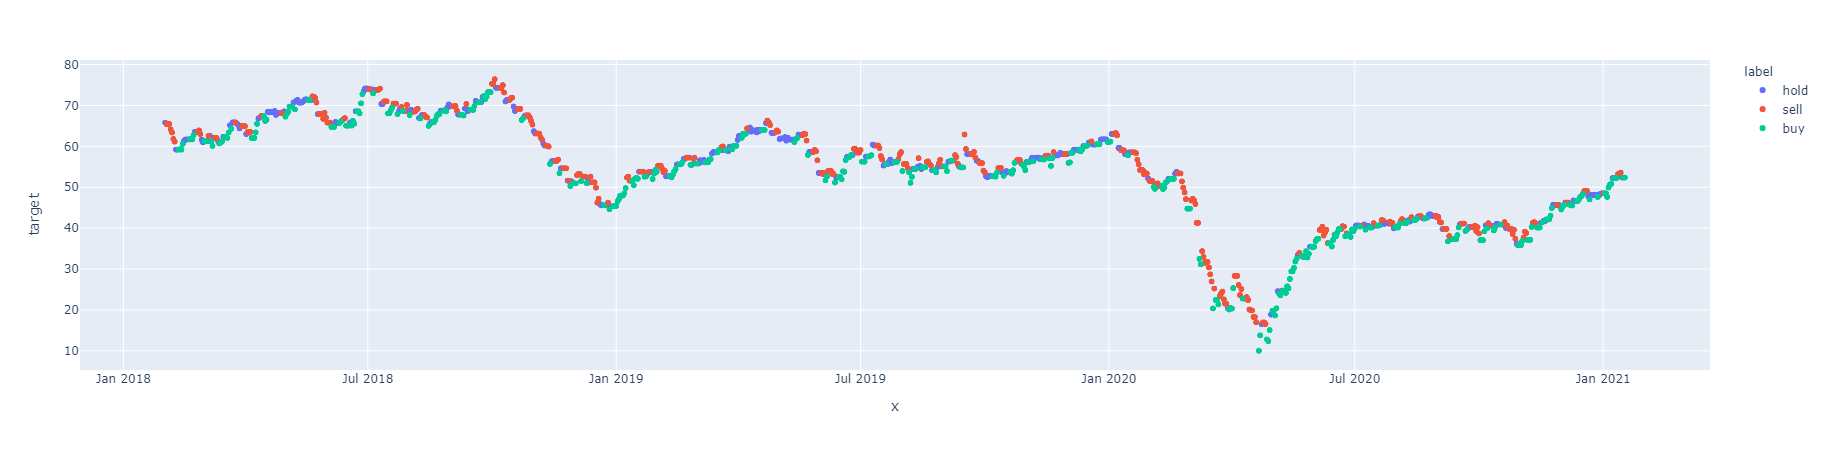

In [35]:
fig = px.scatter(df.dropna(), x=df.dropna().index, y="target", color='label')
fig.show()

In [25]:
cap, log = Simulation(100).play_simulation(df)
log

,type,price,vol,cap,cur_vol
0,buy,63.490002,1,36.509998,1
1,sell,66.139999,1,102.649998,0
2,buy,64.500000,1,38.149998,1
3,sell,65.449997,1,103.599995,0
4,buy,59.200001,1,44.399994,1
...,...,...,...,...,...
174,sell,48.520000,574,27856.518216,0
175,buy,48.520000,574,6.037953,574
176,sell,53.209999,574,30548.577428,0
177,buy,52.360001,583,22.697072,583


In [26]:
n = 5
delta = int(n // 2)

accs = []
wls = []

df = prepare_data_without_window(n=n)
for window_len in range(n - delta, n + delta):
    print('Start window_len', window_len)
    df_window = generate_window(df, window_len=window_len)
    acc = best_window_len_cv(df_window, window_len)
    
    accs.append(acc)
    wls.append(window_len)
    print(f'Accuracy: {acc} for window_len {window_len}')

Start window_len 3
Accuracy: 0.5136039509609652 for window_len 3
Start window_len 4
Accuracy: 0.5481351627164113 for window_len 4
Start window_len 5
Accuracy: 0.5707676012373114 for window_len 5
Start window_len 6
Accuracy: 0.583557107691674 for window_len 6


In [27]:
window_len = 10
n = 10
df = prepare_data_without_window(n=n)
df_window = generate_window(df, window_len=window_len)
df_window = add_results_to_df(df_window, window_len)
res, best_res = get_simulation_results(df_window)

print('res', res, '; best res', best_res)

Accuracy: 0.57
res 1239.8300666809082 ; best res 1495.2700424194336


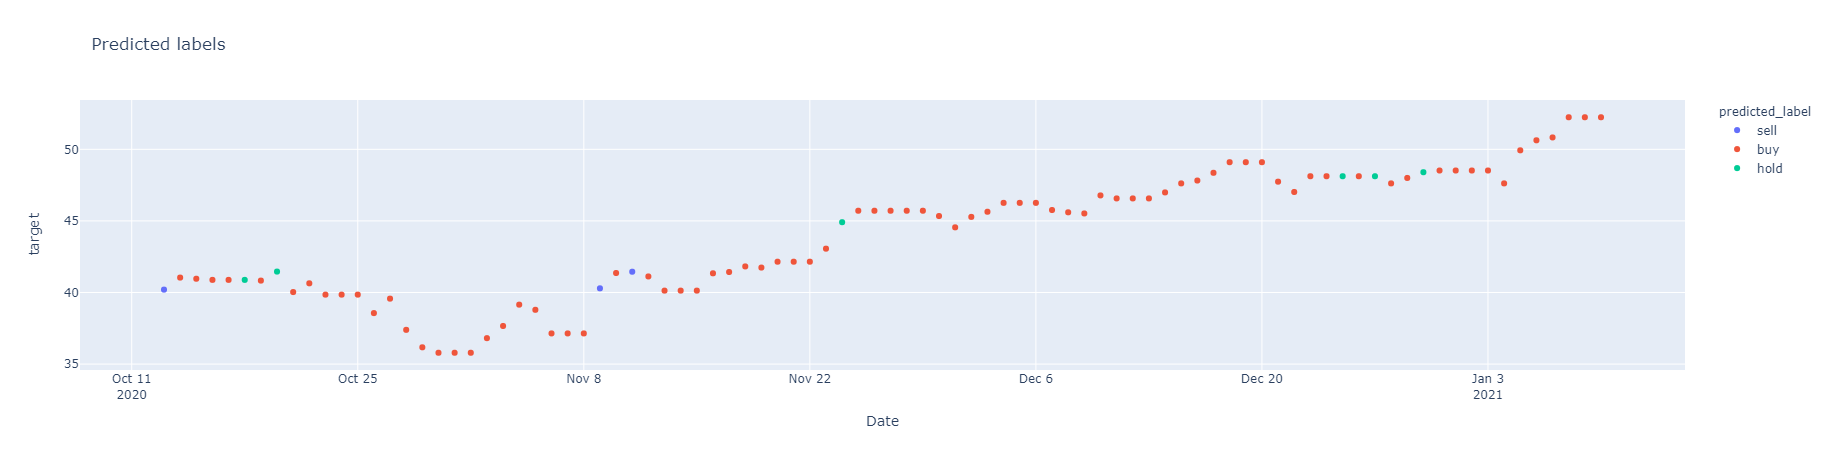

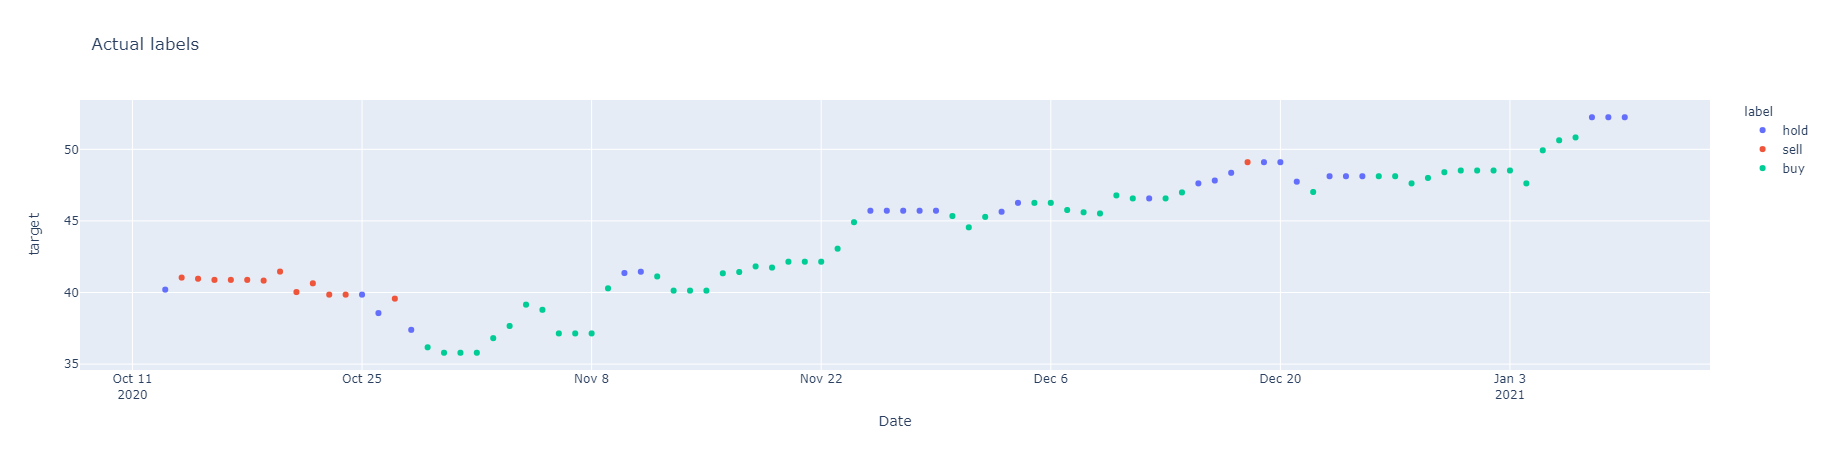

In [28]:
fig = px.scatter(df_window, x=df_window.index, y='target', color='predicted_label', title='Predicted labels')
fig.show()

fig = px.scatter(df_window, x=df_window.index, y='target', color='label', title='Actual labels')
fig.show()